In [1]:
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
import os
# Dataleakage from Kmeans
os.environ["OMP_NUM_THREADS"] = "1"

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 128
EPOCHS = 100
# image_path = "D:/AIF_DCE"
image_path = "D:/iCAT_IMAGES/"
aif_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [2]:
train_images = pd.read_csv(
    './data/combined_train_images.csv', delimiter=',', index_col=0)
train_labels = pd.read_csv(
    './data/combined_train_labels.csv', delimiter=',', index_col=0)
val_images = pd.read_csv(
    './data/combined_val_images.csv', delimiter=',', index_col=0)
val_labels = pd.read_csv(
    './data/combined_val_labels.csv', delimiter=',', index_col=0)
test_images = pd.read_csv('./data/combined_test_images.csv',
                          delimiter=',', index_col=0)
test_labels = pd.read_csv('./data/combined_test_labels.csv',
                          delimiter=',', index_col=0)


### Model Selection
Using train and validation data

In [3]:
from utils.datahandling_utils import SliceIntensityDataset
from torch.utils.data import DataLoader
from utils.datahandling_utils import EqualLengthsBatchSampler

train_dataset = SliceIntensityDataset(
    train_images, train_labels, normalize=True, crop=0.7)
val_dataset = SliceIntensityDataset(
    val_images, val_labels, normalize=True, crop=0.7)
test_dataset = SliceIntensityDataset(
    test_images, test_labels, normalize=True, crop=0.7)


train_sampler = EqualLengthsBatchSampler(BATCH_SIZE, train_images)
val_sampler = EqualLengthsBatchSampler(BATCH_SIZE, val_images)
test_sampler = EqualLengthsBatchSampler(BATCH_SIZE, test_images)

train_loader = DataLoader(train_dataset,
                          shuffle=False, batch_sampler=train_sampler)
val_loader = DataLoader(val_dataset,
                        shuffle=False, batch_sampler=val_sampler)
test_loader = DataLoader(test_dataset,
                         shuffle=False, batch_sampler=test_sampler)


In [4]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from models.dense_net_torch import DenseNet
from utils.model_utils import train, validate


def model_select(config):
    torch.manual_seed(SEED)
    model = DenseNet(growth_rate=config['growth_rate'], num_init_features=config['init_features'],
                     bn_size=config['bn_size'], drop_rate=config['drop_rate'], num_classes=1)
    model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config['lr'])
    criterion = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(EPOCHS):
        train(train_loader, model, criterion, optimizer, device)
        loss = validate(val_loader, model, criterion, device, apr=True)

        tune.report(val_loss=loss[0].item(
        ), accuracy=loss[1], precision=loss[2], recall=loss[3])


In [ ]:

search_space = {
    'growth_rate': tune.randint(10, 17),
    'init_features': tune.randint(20, 30),
    'bn_size': tune.randint(2, 7),
    'drop_rate': tune.uniform(0., 0.3),
    'lr': tune.loguniform(1e-6, 1e-3),
}

asha_scheduler = ASHAScheduler(
    metric="val_loss", mode="min", grace_period=10, max_t=EPOCHS+1, reduction_factor=3)

search = HyperOptSearch(metric="val_loss", mode="min", random_state_seed=SEED)


tuner = tune.Tuner(
    model_select,
    tune_config=tune.TuneConfig(
        num_samples=100,
        max_concurrent_trials=2,
        scheduler=asha_scheduler,
        search_alg=search,
    ),
    param_space=search_space
)

results = tuner.fit()


In [5]:
restored_tuner = tune.Tuner.restore(
    'C:/Users/svenalrik/ray_results/model_select_2023-05-03_10-47-29')
results = restored_tuner.get_results()


In [6]:
best_result = results.get_best_result(metric='val_loss', mode='min')
print(f"The best model achieved a loss of {best_result.metrics['val_loss']}")
print(
    f"with the parameters growth_rate: {best_result.config['growth_rate']} init_features: {best_result.config['init_features']} bn_size: {best_result.config['bn_size']} drop_rate: {round(best_result.config['drop_rate'], 3)} learning_rate: {best_result.config['lr']}")


The best model achieved a loss of 0.009596399962902069
with the parameters growth_rate: 15 init_features: 26 bn_size: 4 drop_rate: 0.018 learning_rate: 3.901202698301639e-05


In [42]:
import json
with open('./trained_models/best_config.txt', 'w') as f:
    f.write(json.dumps(best_result.config))


Training the selected model on training and validation data.
Testing on completely unseen testingdata.

In [7]:
highest_pas = max(np.unique(train_images['Patient']))
pas_length = len(np.unique(val_images['Patient']))

for old, new in zip(np.unique(val_images['Patient']), range(highest_pas + 1, pas_length + highest_pas + 1)):
    val_images.loc[val_images['Patient']
                   == old, 'Patient'] = new
    val_labels.loc[val_labels['Patient']
                   == old, 'Patient'] = new


In [8]:
combined_images = pd.concat((train_images, val_images))
combined_labels = pd.concat((train_labels, val_labels))

train_val_images = combined_images.reset_index(drop=True)
train_val_labels = combined_labels.reset_index(drop=True)


In [9]:
train_val_sampler = EqualLengthsBatchSampler(BATCH_SIZE, train_val_images)


In [10]:
train_val_dataset = SliceIntensityDataset(
    train_val_images, train_val_labels, normalize=True, crop=0.7)
train_val_loader = DataLoader(
    train_val_dataset, shuffle=False, batch_sampler=train_val_sampler)


In [16]:
from torch import nn
from utils.model_utils import train_and_eval
torch.manual_seed(SEED)
model = DenseNet(growth_rate=best_result.config['growth_rate'], num_init_features=best_result.config['init_features'],
                 bn_size=best_result.config['bn_size'], drop_rate=best_result.config['drop_rate'], num_classes=1)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(
), lr=best_result.config['lr'])

losses = train_and_eval(model, train_val_loader, test_loader,
                        optimizer, criterion, EPOCHS, device)


Epoch 5 of 100
Validation - Accuracy 0.92 Precision 0.74 and Recall 0.84
Training loss 0.06978633999824524, validation loss 0.015523734502494335

Epoch 10 of 100
Validation - Accuracy 0.94 Precision 0.83 and Recall 0.84
Training loss 0.026753464713692665, validation loss 0.00957123190164566

Epoch 15 of 100
Validation - Accuracy 0.95 Precision 0.88 and Recall 0.85
Training loss 0.014215496368706226, validation loss 0.00816158764064312

Epoch 20 of 100
Validation - Accuracy 0.94 Precision 0.86 and Recall 0.8
Training loss 0.007327292114496231, validation loss 0.00814642384648323

Epoch 25 of 100
Validation - Accuracy 0.94 Precision 0.82 and Recall 0.87
Training loss 0.003911928739398718, validation loss 0.00865361001342535

Epoch 30 of 100
Validation - Accuracy 0.94 Precision 0.82 and Recall 0.84
Training loss 0.002775450935587287, validation loss 0.008480142802000046

Epoch 35 of 100
Validation - Accuracy 0.94 Precision 0.82 and Recall 0.85
Training loss 0.0019424126949161291, validati

In [14]:
import datetime
curr_date = datetime.datetime.now()
torch.save(model.state_dict(
), f"./trained_models/model_{EPOCHS}_{curr_date.year}_{curr_date.month}_{curr_date.day}.pt")


In [22]:
from utils.model_utils import get_model_performance_metrics
train_val_sorted = get_model_performance_metrics(
    model, train_val_images, train_val_labels, device, True, 0.7)
test_sorted = get_model_performance_metrics(
    model, test_images, test_labels, device, True, 0.7)


In [23]:
print("Performance on training data:")
print(
    f"TP: {len(train_val_sorted[0])} FP: {len(train_val_sorted[1])} TN: {len(train_val_sorted[2])} FN: {len(train_val_sorted[3])}\n")
print("Performance on test data:")
print(
    f"TP: {len(test_sorted[0])} FP: {len(test_sorted[1])} TN: {len(test_sorted[2])} FN: {len(test_sorted[3])}\n")


Performance on training data:
TP: 1388 FP: 0 TN: 3224 FN: 4

Performance on test data:
TP: 128 FP: 19 TN: 661 FN: 23



In [24]:
import matplotlib.pyplot as plt
# Fonts similar to latex document
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


In [ ]:

plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
plt.plot(losses[0][:, 0], label='Training loss')
plt.plot(losses[0][:, 1], label='Validation loss')
plt.xlabel('Epoch')
plt.minorticks_on()
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend(loc='upper right')


In [23]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
plt.plot(losses[1][:, 0], label='Validation accuracy')
plt.plot(losses[1][:, 1], label='Validation precision')
plt.plot(losses[1][:, 2], label='Validation recall')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.minorticks_on()
plt.title('Accuracy, Precision, Recall')
plt.legend(loc='lower right')


NameError: name 'losses' is not defined

<Figure size 1200x600 with 0 Axes>

FP: 0 D:/sailor_DCE/004/08/DCE/1419.dcm
FP: 1 D:/sailor_DCE/004/04/DCE/819.dcm
FP: 2 D:/sailor_DCE/006/08/DCE/1421.dcm
FP: 3 D:/sailor_DCE/006/13/DCE/1419.dcm


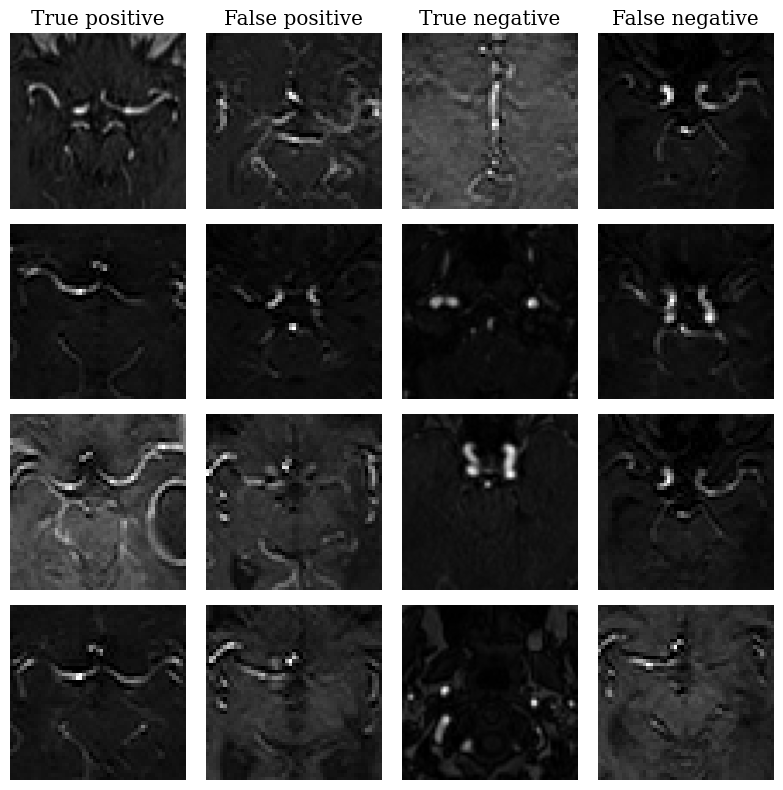

In [26]:
from utils.visualization_utils import display_predictions
display_predictions(test_sorted, model, device, False, True, 0.7)


In [12]:
import json
with open('./trained_models/best_config.txt', 'r') as f:
    data = f.read()
    best_config = json.loads(data)
from models.dense_net_torch import DenseNet
from torch import nn
torch.manual_seed(SEED)
model = DenseNet(growth_rate=best_config['growth_rate'], num_init_features=best_config['init_features'],
                 bn_size=best_config['bn_size'], drop_rate=best_config['drop_rate'], num_classes=1)
print(
    f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_config['lr'])
torch.cuda.empty_cache()
model.load_state_dict(torch.load('./trained_models/model_100_2023_5_4.pt'))
model = model.to(device)
model.eval()


Total number of trainable parameters 1541315


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 26, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(26, 60, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(60, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(41, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

In [28]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
from utils.model_utils import predict


def predict(loader, model, device: str):
    predictions = []
    labels = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for (input, target) in loader:
            target = torch.unsqueeze(target, 1)
            target = target.to(device)
            input = input.to(device)
            output = torch.sigmoid(model(input))

            predictions.extend(output.numpy())
            labels.extend(target.numpy())
    predictions = np.array(predictions)
    labels = np.array(labels)
    return predictions, labels


preds, labels = predict(test_loader, model, 'cpu')


In [31]:
fpr, tpr, thresholds = roc_curve(labels, preds)
auc_score = roc_auc_score(labels, preds)


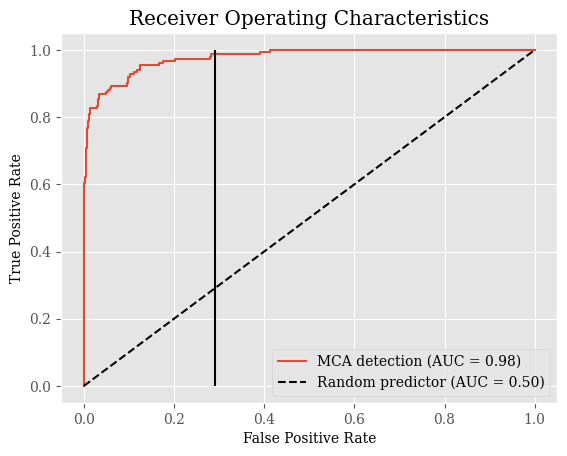

In [49]:
plt.plot(fpr.squeeze(), tpr.squeeze(),
         label=f"MCA detection (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random predictor (AUC = 0.50)")
plt.vlines(0.29, 0, 1, colors='black', )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc='lower right')


In [56]:
thresholds[thresholds >
           0.5]


array([1.9999868 , 0.99998677, 0.9849899 , 0.9849576 , 0.9776382 ,
       0.97685075, 0.9749102 , 0.97197896, 0.96974784, 0.9692229 ,
       0.9490152 , 0.94235194, 0.9219223 , 0.9166986 , 0.8995722 ,
       0.8914059 , 0.87745017, 0.8736819 , 0.8439356 , 0.8300146 ,
       0.8297487 , 0.82397336, 0.8172853 , 0.6773346 , 0.64902765,
       0.63003063, 0.61715037, 0.5918589 , 0.5465731 ], dtype=float32)

In [54]:
len(fpr)


68